# Readability

In [9]:
import pandas as pd
from textstat.textstat import easy_word_set
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from collections import Counter
import re, os

## Defining some basic lexicons and measures

Textstat.easywordset (imported above) gives us a conventional list of 3,000 "easy words" that is used, for instance in the Dale-Chall readability measure.

We also need a large lexicon of 600,000 words that will include almost all English words. We'll use this below to identify proper nouns: things not in the large_lexicon, and capitalized, will be presumed to be proper nouns.

In [2]:
large_lexicon = set()

with open('../../DataMunging/rulesets/MainDictionary.txt', encoding = 'utf-8') as f:
    for line in f:
        fields = line.strip().split('\t')
        large_lexicon.add(fields[0])        

#### functions that count syllables

In [26]:
def syllable_count(word):
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
            if word.endswith("e"):
                count -= 1
    if count == 0:
        count += 1
    return count

def text_syllables(text):
    words = text.split()
    syllables = 0
    one_syllable_count = 0
    polysyllable_count = 0
    wordcount = 0
    
    for w in words:
        w = w.strip('.,!?)([])-1234567890\"').lower()
        if len(w) > 0:
            wordcount += 1
            this_syllable = syllable_count(w)
            syllables += this_syllable
            if this_syllable < 2:
                one_syllable_count += 1
            elif this_syllable >= 3:
                polysyllable_count += 1
    
    return syllables, one_syllable_count, polysyllable_count, wordcount
        
def polysyllable_count(text):
    words = text.split()
    wordcount = len(words)
    if wordcount < 1:
        return 0
    
    polysyllable = 0
    
    for w in words:
        w = w.strip('.,!?)([])-')
        syllable_count = syllables_count(w)
        if syllable_count >= 3:
            polysyllable += 1
    return polysyllable

In [4]:
for w in ['these', 'challenges', 'trouble', 'our', 'hearts', 'and', 'vocabulary', 
          'solution', 'imperfect', 'but', 'I', 'accept']:
    print(w, syllable_count(w))

these 1
challenges 3
trouble 1
our 1
hearts 1
and 1
vocabulary 5
solution 3
imperfect 3
but 1
I 1
accept 2


#### a function that counts "difficult words"

This relies heavily on the Dale-Chall "easy word" list, but refines it in ways borrowed from the Gunning "fog" index: by excluding not just easy words but relatively short words, proper nouns, and easy words + -ed or -s from our list of "difficult words."

I think this is probably the measure best suited to oral argument.

In [5]:
propernouns = Counter()
hardwords = Counter()

def difficult_word_pct(text):
    global large_lexicon, propernouns, hardwords, easy_word_set
    
    words = text.split()
    wordcount = len(words)
    if wordcount < 1:
        return 0.2
    
    difficult = 0
    
    for w in words:
        
        w = w.strip('.,!?)([])-')
        if len(w) > 0 and w[0].isupper():
            capitalized = True
        else:
            capitalized = False
        w = w.lower()
        
        if w in easy_word_set:
            continue
            
        if len(w) < 7:
            continue
        
        if w.endswith('ed'):
            if w[0 : -2] in easy_word_set:
                continue
        
        if w.endswith('s'):
            if w[0 : -1] in easy_word_set:
                continue
        
        if capitalized and w not in large_lexicon:
            w = w[0].upper() + w[1: ]
            propernouns[w] += 1
        
        if '-' in w:
            wparts = w.split('-')
            allok = True
            for wpart in wparts:
                if wpart not in easy_word_set and len(wpart) > 2:
                    allok = False
            if not allok:
                difficult += 1
                hardwords[w] += 1
        else:
            difficult += 1
            hardwords[w] += 1
        
    return difficult/wordcount

#### a function that divides text into sentences

This is shamelessly borrowed from Stack Overflow. It deals with a lot of edge cases pretty well.

In [6]:
# The code below is directly borrowed from Deduplicator at
# https://stackoverflow.com/questions/4576077/python-split-text-on-sentences

caps = "([A-Z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + caps + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(caps + "[.]" + caps + "[.]" + caps + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(caps + "[.]" + caps + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + caps + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [7]:
text = "This is a story about Mr. John Johnson, Jr., who is our hero. He laughs!  \
He sings about the F.B.I! Is it a good story? Unfortunately it's not.It ends anticlimactically."
split_into_sentences(text)

['This is a story about Mr. John Johnson, Jr., who is our hero.',
 'He laughs!',
 'He sings about the F.B.I!',
 'Is it a good story?',
 "Unfortunately it's not.",
 'It ends anticlimactically.']

## Actually computing readability measures

Our strategy is to proceed term by term, using the files previously produced by build_term_datasets.ipynb. Each row here represents everything said by one justice about one case.

In each term we iterate through the rows. We ignore extremely short rows with 1 or 2 words. But otherwise we calculate a bunch of metrics for the row and add them to lists. When we're done with a term, we take the *median* for each metric's list, and consider that the yearly value.

The formulas I'm using for each metric are, at the moment, drawn directly from
https://en.wikipedia.org/wiki/Readability#The_Gunning_fog_formula

For a publishable version I would trace back to the original publications.

In [27]:
terms = []
fog_vals = []
diff_vals = []
sl_vals = []
smog_vals = []
wordlen_vals = []
flesch_vals = []
dalechall_vals = []
syllable_vals = []
threesyll_vals = []

all_frames = []

for term in range(1955, 2015):
    if term == 1981:
        continue
        
    print(term)
    infile = '/Volumes/TARDIS/oralarg/termgrouped/term' + str(term) + '.tsv'
    if not os.path.isfile(infile):
        continue
    else:
        data = pd.read_csv(infile, sep = '\t')
    
    fog = []
    diffpcts = []
    sl = []
    
    counts_used = []
    cases_used = []
    justices_used = []
    terms_used = []
    speakercases = []
    smogs = []
    wordlens = []
    flesches = []
    dalechalls = []
    syllablesperword = []
    threesyllables = []
    
    ctr = 0
    for idx, row in data.iterrows():
        text = row['text']
        count = row['wordct']
        speakercase = row['speakercase']
        justice = row['justice']
        case = '-'.join(speakercase.split('-')[0:-1])
        
        
        if count < 3:
            continue
        else:
            counts_used.append(count)
            justices_used.append(justice)
            terms_used.append(term)
            cases_used.append(case)
            speakercases.append(speakercase)
                  
        sentences = split_into_sentences(text)
        sentcount = len(sentences)
        
        syllablecount, one_syllable_words, three_or_more_syllables, count = text_syllables(text)
        # notice that we replace previous count with this more accurate one
            
        avg_sent_length = count / (sentcount + 0.01)
        sl.append(avg_sent_length)
        
        flesch = 206.835 - (1.015 * avg_sent_length) - (84.6 * (syllablecount / count))
        flesches.append(flesch)
        
        diffpct = difficult_word_pct(text) * 100
        diffpcts.append(diffpct)
        
        thisfog = 0.4 * (avg_sent_length + diffpct)
        fog.append(thisfog)
        
        #poly_syllab = polysyllable_count(text)
        # SMOG = (1.043 * (30*(poly_syllab / sentcount))**0.5)  + 3.1291
        #smogs.append(SMOG)
        
        wordlenlist = [len(x.strip('.,()[]!?')) for x in text.split()]
        wordlens.append(np.mean(wordlenlist))
        
        dalechall = (0.1579 * diffpct) + (0.0496 * avg_sent_length) + 3.6365
        dalechalls.append(dalechall)
        
        syllablesperword.append(syllablecount / count)
        
        threesyllables.append(three_or_more_syllables / count)
        
    
    # flesch_vals.append(np.mean(flesch))
    diffmedian = np.median(diffpcts)
    diff_vals.append(diffmedian)
    
    fogmedian = np.median(fog)
    fog_vals.append(fogmedian)
    smogmedian = np.median(smogs)
    smog_vals.append(smogmedian)
    wordlength = np.median(wordlens)
    wordlen_vals.append(wordlength)
    sl_vals.append(np.median(sl)) 
    flesch_vals.append(np.median(flesches))
    dalechall_vals.append(np.median(dalechalls))
    syllable_vals.append(np.median(syllablesperword))
    threesyll_vals.append(np.median(threesyllables))
    
    # smog_vals.append(np.median(smogs))
    
    terms.append(term)
    
    df = pd.DataFrame({'case': cases_used, 'justice': justices_used, 'speakercase': speakercases, 
                    'difficultpct': diffpcts, 'sentlength': sl, 'fog': fog, 'term': terms_used,
                      'flesch': flesches, 'dalechall': dalechalls})
    all_frames.append(df)

1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014


/Users/tunder/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/tunder/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### average word length

Higher lengths are more difficult. Note that this is a pretty bad measure, because most words are short, so this gets dominated by difference between "a" and "these," neither of which are in reality hard words.

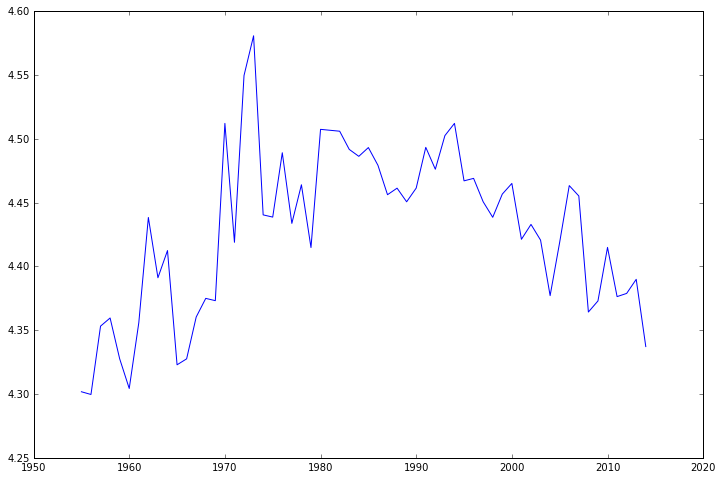

In [25]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(terms, wordlen_vals)
plt.show()

### percentage of difficult words

This is a considerably better measure, which focuses attention at the high end of the lexicon where things actually get hard. Notice also that it does *generally* track the pattern of "word length." There's a decline from the early 70s to the present.

This is probably the measure I trust most.

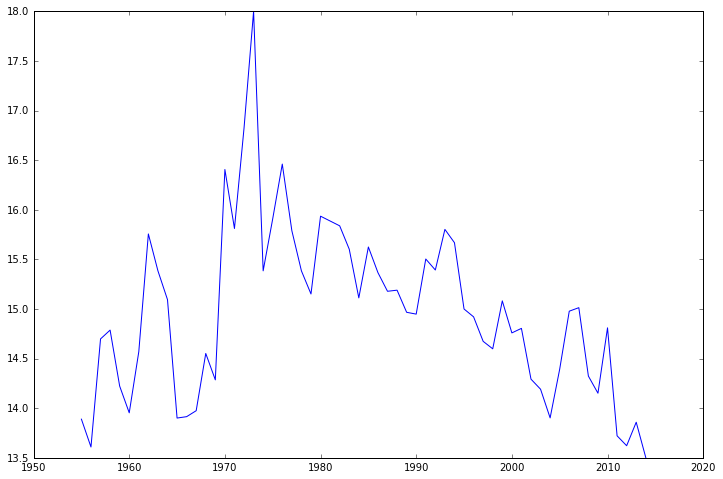

In [23]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(terms, diff_vals)
plt.savefig('percentdifficultwords.png')
plt.show()

### average syllables per word

A slightly different picture, but broadly congruent with the trends above.

We have a causal hypothesis for the increasing accessibility of language 1970 to the present. Do we have anything to explain the increase in word length around 1965?


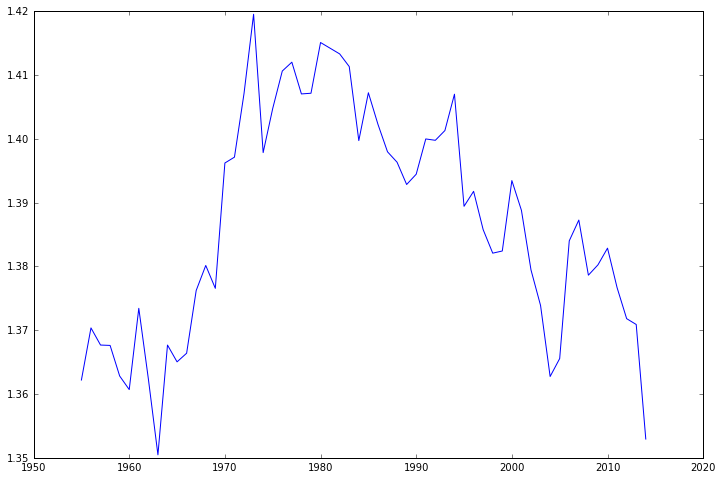

In [24]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(terms, syllable_vals)
plt.show()

### fraction of words three syllables or more

Again, broadly similar.

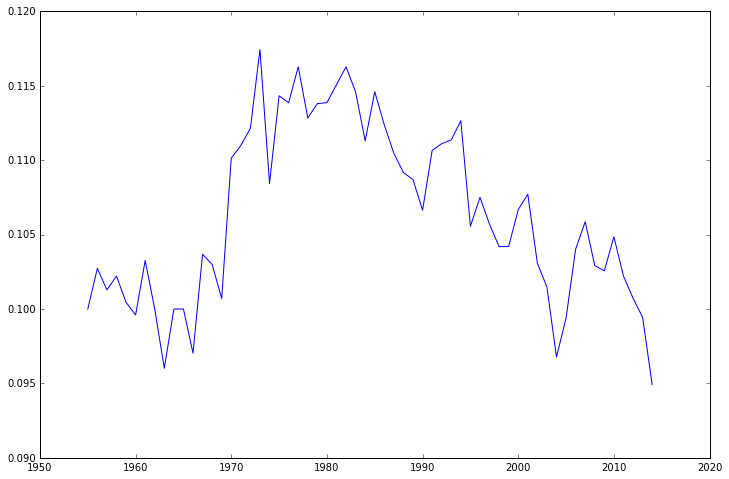

In [28]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(terms, threesyll_vals)
plt.show()

### average sentence length

There are lots of reasons not to trust this. In a transcription, sentence length is probably controlled more by the transcriber's punctuation choices than by the speaker; you see what I mean?

But here it is. The abrupt and dramatic shifts here look to me suspiciously like different transcribers. But fwiw, if it were real, the decline from 70s to early 2000s would echo the decline seen above.

There's a return to long sentences at the end, though.

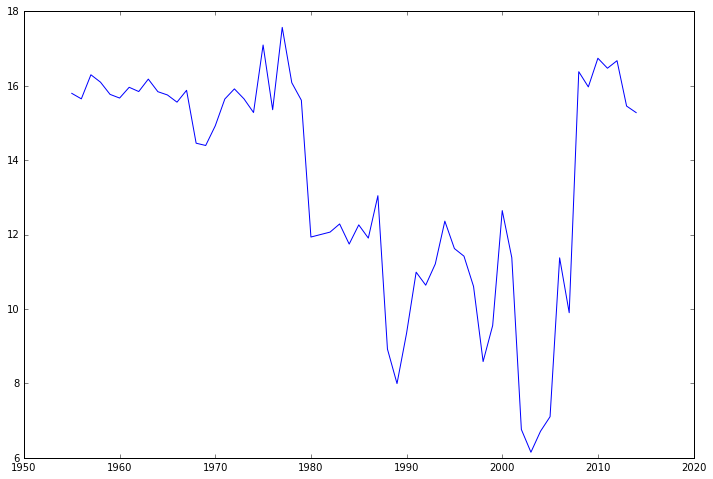

In [29]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(terms, sl_vals)
plt.show()

### fog index

There are lots and lots of ways to combine sentence length with measures of diction difficulty. The Gunning fog index is one. I'm not sure I've calculated it strictly correctly; I think I should use syllable count rather than the Dale-Chall list to define "difficult words." But this is 

    0.4 * (avg_sentence_length + pct_difficult_words)


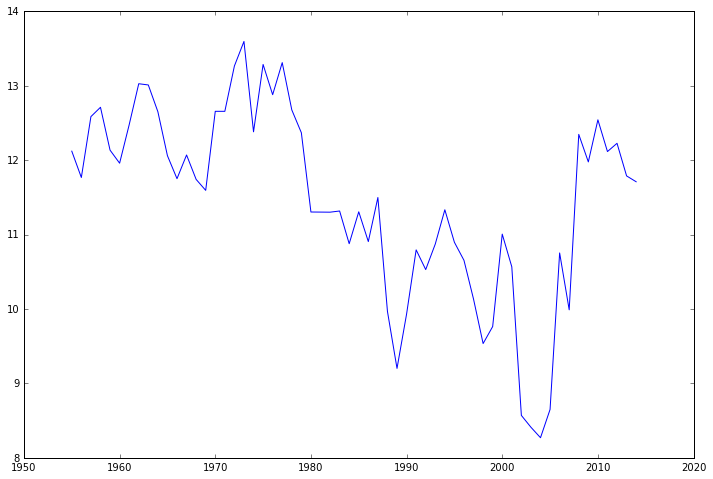

In [30]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(terms, fog_vals)
plt.show()

### Dale-Chall

The Dale-Chall formula is one of the best of the readability metrics; it correlates at 0.93 with comprehension as measured on reading tests. And it broadly fits the "difficult words" trajectory, with just a slight uptick in the last ten years. It is:

    (0.1579 * pct_difficult_words) + (0.0496 * avg_sentence_length) + 3.6365

The values here probably underestimate the grade level because I exclude more categories from "difficult words" than Dale & Chall did.

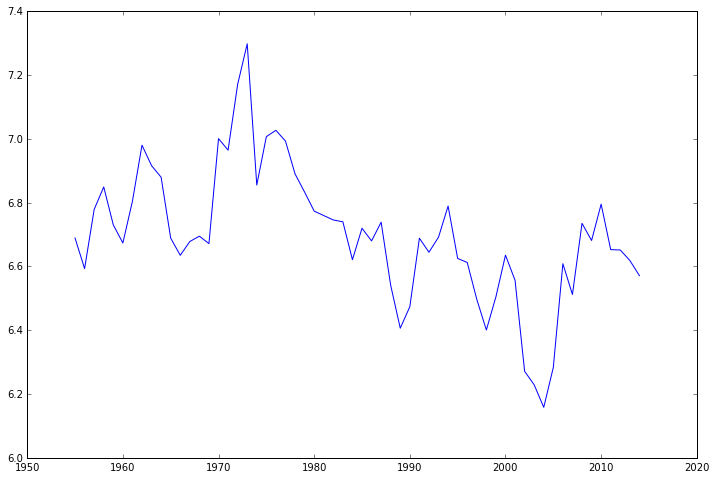

In [31]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(terms, dalechall_vals)
plt.show()

### Flesch-Kincaid readability

One of the oldest metrics; correlates at .7 with reading comprehension tests.

    206.835 − (1.015 * average_sentence_length) − (84.6 * average_syllables_per_word)
   
On this scale higher values are *more* readable. That's the reverse of everything above, so I've flipped the y axis to keep things congruent and immediately intepretable.

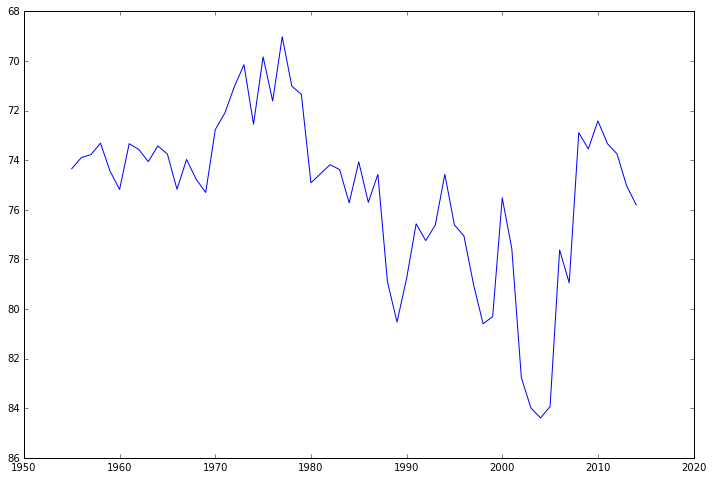

In [32]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(terms, flesch_vals)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

## Producing data and writing to file

In [191]:
readability = pd.concat(all_frames, ignore_index = True)
readability.shape

(39868, 9)

In [161]:
readability.to_csv('../results/readability.tsv', sep = '\t', index = False)

In [162]:
justices = []
terms = []
meandiff = []

by_justice = readability.groupby(['justice', 'term'])
for justterm, df in by_justice:
    mean_difficulty = np.mean(df.difficultpct)
    justice, term = justterm
    justices.append(justice)
    terms.append(term)
    meandiff.append(mean_difficulty)

df = pd.DataFrame({'justice': justices, 'term': terms, 'meandiff': meandiff})

In [163]:
df.to_csv('../results/difficulty_by_justice_and_term.tsv', sep = '\t', index = False)

In [164]:
cases = []
meandiff = []

by_cases = readability.groupby('case')
for case, df in by_cases:
    mean_difficulty = np.mean(df.difficultpct)
    cases.append(case)
    meandiff.append(mean_difficulty)

df = pd.DataFrame({'case': cases, 'meandiff': meandiff})
df.to_csv('../results/difficulty_by_case.tsv', sep = '\t', index = False)

In [107]:
data.head()

,justice,mq,speakercase,text,wordct
0,AMKennedy,-0.270,2014-001-AMKennedy,"So suppose that this State, North Carolina, di...",420
1,AScalia,1.487,2014-001-AScalia,"But Mr. Fisher, we -- we don't review opinions...",1131
2,EKagan,-1.641,2014-001-EKagan,"Mr. -- Mr. Fisher, suppose this were a Federal...",549
3,JGRoberts,0.561,2014-001-JGRoberts,Our first case this morning is Heien v. North ...,491
4,RBGinsburg,-2.474,2014-001-RBGinsburg,"Mr. Fisher, I have a preliminary question.\nEv...",385


In [121]:
'the' in easy_word_set

True

In [146]:
hardest = hardwords.most_common(10000)

In [149]:
with open('hardwords.txt', mode = 'w',encoding = 'utf-8') as f:
    for word in hardest:
        f.write(word[0] + '\n')

In [150]:
properest = propernouns.most_common(10000)

In [151]:
with open('propernouns.txt', mode = 'w',encoding = 'utf-8') as f:
    for word in properest:
        f.write(word[0] + '\n')

In [166]:
by_justice = readability.groupby('justice')
for justice, df in by_justice:
    mean_difficulty = np.mean(df.difficultpct)
    print(justice, mean_difficulty)

AFortas 15.5576175772
AJGoldberg 36.1051371721
AMKennedy 15.7919507805
AScalia 14.2158447279
BRWhite 14.4208198503
CEWhittaker 16.9771222724
CThomas 17.3612728783
DHSouter 14.950943833
EKagan 14.1658549152
EWarren 15.3922243942
FFrankfurter 15.1861936211
HABlackmun 14.9861531871
HHBurton 13.9959683952
HLBlack 12.9126013679
JGRoberts 15.2550119318
JHarlan2 16.8043368512
JPStevens 14.897865816
LFPowell 16.8540628727
PStewart 15.3526606986
RBGinsburg 14.5423409381
SAAlito 16.0473682014
SDOConnor 17.0576125452
SFReed 13.5342775772
SGBreyer 11.7332002613
SMinton 14.173343146
SSotomayor 14.961842412
TCClark 15.4345681272
WEBurger 16.1375280054
WHRehnquist 17.0090427155
WJBrennan 15.8372102525
WODouglas 14.6740694846
